# Recurrent Neural Networks, LSTMs and GRUs

Learning Outcomes:
- Understand RNN architecture and training via backpropagation through time
- ...

Tasks:

In [1]:
## Library imports
import random

import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Coding a RNN from scratch
In this section we will code a RNN from scratch using numpy. The network will perform the task of "next character generation".

## 1.1. Data
In order to train to you RNN, go to [Project Gutemberg](https://www.gutenberg.org/) and choose a book that you like. Copy paste it as plain text in a text file called `book.txt` in your current repository.
If you struggle to choose a book, here are a few options :
- [Les misérables](https://www.gutenberg.org/cache/epub/48735/pg48735.txt)
- [Don Quijote](https://www.gutenberg.org/cache/epub/2000/pg2000.txt)
- [La Divina Commedia](https://www.gutenberg.org/cache/epub/997/pg997.txt)
- [L'avare](https://www.gutenberg.org/cache/epub/6318/pg6318.txt)

**Exercise.** Once the book of your choice is copied onto `book.txt` write a `load_data` function that:
1. Reads the file `book.txt` and returns it as a string.
2. Returns a sorted list containing all unique characters in the book.
3. Returns the number of unique characters.
4. Returns a dictionary mapping the characters in the alphabet to unique numerical indexes.
5. Returns a dictionary to perform the reverse mapping.

In [24]:
    # Load and preprocess the dataset
    def load_data(file_path):
        #TODO: Load the data from the file and store it in the variable text
        with open(file_path, 'r', encoding='utf-8') as f :
            text = f.read()
        chars = sorted(set(text)) #TODO: Find the unique characters in the text
        vocab_size = len(chars) #TODO: Find the number of unique characters in the text
        char_to_ix = {ch : i for i, ch in enumerate(chars)} #TODO: Create a dictionary that maps characters to indices
        ix_to_char = {i : ch for i, ch in enumerate(chars)} #TODO: Create a dictionary that maps indices to characters
        return text, chars, vocab_size, char_to_ix, ix_to_char

In [16]:
# Load and preprocess the dataset
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    chars = sorted(set(text))
    print(chars)
    vocab_size = len(chars)
    char_to_ix = {ch: i for i, ch in enumerate(chars)}
    ix_to_char = {i: ch for i, ch in enumerate(chars)}
    return text, chars, vocab_size, char_to_ix, ix_to_char

In [23]:
text, chars, vocab_size, char_to_ix, ix_to_char = load_data('book.txt')
print(f"The book has {len(text)} characters and {vocab_size} unique characters")

The book has 174809 characters and 107 unique characters


In [25]:
# An excerpt from the book
print(text[100000:100500])

 qu'indifférent.

  Son pareil le suivait: barbe, oeil, dos, bâton, loques,
  Nul trait ne distinguait, du même enfer venu,
  Ce jumeau centenaire, et ces spectres baroques
  Marchaient du même pas vers un but inconnu.

  A quel complot infâme étais-je donc en butte,
  Ou quel méchant hasard ainsi m'humiliait?
  Car je comptai sept fois, de minute en minute,
  Ce sinistre vieillard qui se multipliait!

  Que celui-là qui rit de mon inquiétude,
  Et qui n'est pas saisi d'un frisson fraternel
  So


## 1.2. The RNN architecture
We will build a simple RNN architecture obeying to the following formulas:
\begin{align*}
a_t &= \tanh(W_{aa}a_{t-1} + W_{ax}x_t + b_a)\\
\hat{y}_t &= W_{ya}a_t + b_y\\
\hat{o}_t &= \text{softmax}(\hat{y}_t)
\end{align*}
In order to do so, we will define a class called RNN. The class RNN will consist of several different methods:
- An `__init__` method, where the different weight matrices and bias vectors should be initialized as follows:
    - The vocabulary size, and hidden state size should be passed as arguments on initialization and stored for future use.
    - The weight matrices should be initialized to have i.i.d. entries with distribution $\mathcal{N}(0, 0.001)$.
    - The bias vectors should be initialized to 0.
    - In addition we will initialize parameters necessary for the AdaGrad optimization algorith
- A `forward` method, where the above formulas should be implemented.
- A `compute_gradients` method, where the formulas for backpropagation through time should be implemented and the gradients of the different weight matrices and bias vectors computed.
- A `backward_adagrad` method that will update the values of the different weight matrices and bias vectors using the gradients values and the AdaGrad algorithm.
- A `sample` method to sample a new sentence of a given length, by providing only the first letter of the sentence.

In the sequel we will implement these five methods step by step.

### 1.2.1. The `__init__` method
**Exercise.** Complete the `__init__` method below by filling in the `TODO` flags.

In [ ]:
class RNN:

    def __init__(self, vocab_size, hidden_size=64):
        # TODO: store the model parameters in variables of the same name

        # TODO: initialize the model weights and biases
        self.Waa = ...
        self.Wax = ...
        self.Wya = ...
        self.ba = ...
        self.by = ...

        # AdaGrad optimization parameters
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}

    
    def forward(self):
        pass


    def compute_gradients(self):
        pass


    def backward_adagrad(self):
        pass


    def sample(self):
        pass

### 1.2.2. The `forward` method
**Exercise.** Complete the `forward` method by filling in the `TODO` flags below.

In [ ]:
class RNN:
    # Simple "vanilla" RNN model

    def __init__(self, vocab_size, hidden_size=64):
        # Store the model hyperparameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Initialize the model weights and biases
        self.Waa = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wax = np.random.randn(hidden_size, vocab_size) / 1000
        self.Wya = np.random.randn(vocab_size, hidden_size) / 1000
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
        # AdaGrad optimization parameters
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}
        

    def forward(self, inputs, h_prev):
        """
        Perform forward pass.
        Args:
            inputs: One-hot encoded inputs of shape (vocab_size, seq_length)
            h_prev: Initial hidden state of shape (hidden_size, 1)
        Returns:
            outputs: List of output probabilities
            hs: List of hidden states
        """
        # Initialize hidden state, logits, and output pobabilities
        hs, ys, ps = {}, {}, {}
        hs[-1] = np.copy(h_prev)

        for t, x in enumerate(inputs):
            # TODO: update the hidden state
            hs[t] = ...

            # TODO: compute the output logits
            ys[t] = ...

            # TODO: compute the softmax probabilities
            ps[t] = ...

        # We return the whole history of output probabilities and hidden states 
        # since we will need them for the backpropagation
        return ps, hs
    

    def compute_gradients(self):
        pass


    def backward_adagrad(self):
        pass


    def sample(self):
        pass

### 1.2.3. The `compute_gradients` method
In order to train our RNN we need to implement the BPTT algorith. We will use the cross-entropy loss, which is the common practice associated with the softmax function. For an output sequence of length $T$, let us denote by $(y_t)_{t=1}^T$ the sequence of ground truth index values, and let us denote by $(\hat{y}_t)_{t=1}^T$ the sequence outputed by the RNN (i.e. the vector of subsequent logit values).
We wish to optimize the loss function
$$\mathcal{L}=\sum_{t=1}^T L_t$$
where each term $L_t$ is given by the negative log-likelihood of the ground truth output under the current model:
$$\displaystyle L_t = -\log \hat{o}_t(y_t) = -\log \text{softmax}_{y_t}(\hat{y}_t).$$

In order to ease our calculations, we introduce the following notation:
\begin{align*}
dW_{ax} := \frac{\partial\mathcal{L}}{\partial W_{ax}}
dW_{aa} := \frac{\partial\mathcal{L}}{\partial W_{aa}}
dW_{ya} := \frac{\partial\mathcal{L}}{\partial W_{ya}}
db_{a} := \frac{\partial\mathcal{L}}{\partial b_{a}}
db_{y} := \frac{\partial\mathcal{L}}{\partial b_{y}}
\end{align*}
The objective of the `compute_gradients` methods is to compute the above quantities. We will do so iteratively by traveling backward over the unfolded RNN graph, here is the pseude-code to implement the `compute_gradients` method:

For $t = T, T-1, \dots, 1$:
- compute $dy_t:=\frac{\partial \mathcal{L}}{\partial \hat{y}_t}$.
- update $dW_{ya}$ and $db_a$.
- backpropagate the gradient to the hidden layer, i.e. compute 
$dh_t := \frac{\partial \mathcal{L}}{\partial h_t}$.


- update $dW_{aa}$, $dW_{xa}$ and $db_a$ using the chain rule: for example, for $dW_{aa}$
$$dW_{aa} := \frac{\partial\mathcal{L}}{\partial W_{aa}}= \sum_{t=1}^T \frac{\partial h_t}{\partial W_{aa}} \frac{\partial\mathcal{L}}{\partial h_t}.$$


**Exercise.** Compute the necessary quantities to deploy the pseudo-code above:
1. Find a formula for $dy_t$.
2. Find a formula to compute $dW_{ya}$ and $db_a$ as a function of the $dy_1,\dots,dy_T$.
3. Find a formula to compute $dh_t$ as a function of $dy_t$ and $dh_{t+1}$.
4. Find formulas to compute $dW_{aa}$, $dW_{ax}$ and $db_a$ as functions of $dh_1,\dots,dh_T$.

**Use pen and paper! Ask the teachers if you struggle!** 

**Exercise.** Complete the `compute_gradients` methods by filling in the `TODO` flags.

In [ ]:
class RNN:
    # Simple "vanilla" RNN model

    def __init__(self, vocab_size, hidden_size=64):
        # Store the model hyperparameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Initialize the model weights and biases
        self.Waa = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wax = np.random.randn(hidden_size, vocab_size) / 1000
        self.Wya = np.random.randn(vocab_size, hidden_size) / 1000
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
        # AdaGrad optimization parameters
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}


    def forward(self, inputs, h_prev):
        """
        Perform forward pass.
        Args:
            inputs: One-hot encoded inputs of shape (vocab_size, seq_length)
            h_prev: Initial hidden state of shape (hidden_size, 1)
        Returns:
            outputs: List of output probabilities
            hs: List of hidden states
        """
        # Initialize hidden state, logits, and output pobabilities
        hs, ys, ps = {}, {}, {}
        hs[-1] = np.copy(h_prev)

        for t, x in enumerate(inputs):
            # Update the hidden state
            hs[t] = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, hs[t-1]) + self.ba)

            # Compute the output logits
            ys[t] = np.dot(self.Wya, hs[t]) + self.by

            # Softmax probabilities
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

        return ps, hs


    def compute_gradients(self, inputs, targets, hs, ps):
        """
        Compute the gradients for one sequence.
        Args:
            inputs: List of one-hot encoded inputs
            targets: List of integer targets
            hs: List of hidden states
            ps: List of output probabilities
        Returns:
            Gradients
        """
        #TODO: Initialize gradients to zero matrices/vectors of the appropriate shapes
        dWax, dWaa, dWya = ...
        dba, dby = ...

        #TODO: Initilized the hidden state gradient to a zero vector of the appropriate size
        dh_next = ...

        # Loop through each time step
        for t in reversed(range(len(targets))):
            # TODO: Compute dy, the derivative of the loss with respect to the output
            dy = ...

            #TODO: Update the gradients of the output layer
            dWya += ...
            dby += ...

            #TODO: Backpropagate the gradient to the hidden layer
            dh = ...
            dh_raw = (1 - hs[t] ** 2) * dh # Backprop through tanh

            # TODO: Update the gradients of the hidden layer
            dWax += ...
            dWaa += ...
            dba += ...

            # Update the next hidden state
            dh_next = ...

        # Clip gradients to mitigate exploding gradients
        for dparam in [dWax, dWaa, dWya, dba, dby]:
            np.clip(dparam, -1, 1, out=dparam)
        
        return dWax, dWaa, dWya, dba, dby
        


    def backward_adagrad(self):
        pass


    def sample(self):
        pass

### 1.2.4. The `backward_adagrad` method
Below we add the adagrad optimization algorithm.

In [ ]:
class RNN:
    # Simple "vanilla" RNN model

    def __init__(self, vocab_size, hidden_size=64):
        # Store the model hyperparameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Initialize the model weights and biases
        self.Waa = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wax = np.random.randn(hidden_size, vocab_size) / 1000
        self.Wya = np.random.randn(vocab_size, hidden_size) / 1000
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
        # AdaGrad optimization parameters
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}
        

    def forward(self, inputs, h_prev):
        """
        Perform forward pass.
        Args:
            inputs: One-hot encoded inputs of shape (vocab_size, seq_length)
            h_prev: Initial hidden state of shape (hidden_size, 1)
        Returns:
            outputs: List of output probabilities
            hs: List of hidden states
        """
        # Initialize hidden state, logits, and output pobabilities
        hs, ys, ps = {}, {}, {}
        hs[-1] = np.copy(h_prev)

        for t, x in enumerate(inputs):
            # Update the hidden state
            hs[t] = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, hs[t-1]) + self.ba)

            # Compute the output logits
            ys[t] = np.dot(self.Wya, hs[t]) + self.by

            # Softmax probabilities
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

        return ps, hs

    def compute_gradients(self, inputs, targets, hs, ps):
        """
        Compute the gradients for one sequence.
        Args:
            inputs: List of one-hot encoded inputs
            targets: List of integer targets
            hs: List of hidden states
            ps: List of output probabilities
        Returns:
            Gradients
        """
        # Initialize gradients
        dWax, dWaa, dWya = np.zeros_like(self.Wax), np.zeros_like(self.Waa), np.zeros_like(self.Wya)
        dba, dby = np.zeros_like(self.ba), np.zeros_like(self.by)
        dh_next = np.zeros_like(hs[0])

        # Loop through each time step
        for t in reversed(range(len(targets))):
            # Compute dy, the derivative of the loss with respect to the output
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1

            # Compute the gradient of the output layer
            dWya += np.dot(dy, hs[t].T)
            dby += dy

            # Backpropagate the gradient to the hidden layer
            dh = np.dot(self.Wya.T, dy) + dh_next
            dh_raw = (1 - hs[t] ** 2) * dh # Backprop through tanh

            # Compute the gradients of the hidden layer
            dWax += np.dot(dh_raw, inputs[t].T)
            dWaa += np.dot(dh_raw, hs[t].T)
            dba += dh_raw

            # Update the next hidden state
            dh_next = np.dot(self.Waa.T, dh_raw)

        # Clip gradients to mitigate exploding gradients
        for dparam in [dWax, dWaa, dWya, dba, dby]:
            np.clip(dparam, -1, 1, out=dparam)
        
        return dWax, dWaa, dWya, dba, dby
        
    
    def backward_adagrad(self, gradients, lr=0.1):
        """
        Update the model parameters using the AdaGrad optimization algorithm.
        Args:
            gradients: List of gradients
            lr: Learning rate
        """
        for param, dparam in zip(['Wax', 'Waa', 'Wya', 'ba', 'by'], gradients):
            self.m[param] += dparam ** 2
            self.__dict__[param] -= lr * dparam / np.sqrt(self.m[param] + 1e-8)


    def sample(self):
        pass

### 1.2.5. The `sample` method

In [ ]:
class RNN:
    # Simple "vanilla" RNN model

    def __init__(self, vocab_size, hidden_size=64):
        # Store the model hyperparameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Initialize the model weights and biases
        self.Waa = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wax = np.random.randn(hidden_size, vocab_size) / 1000
        self.Wya = np.random.randn(vocab_size, hidden_size) / 1000
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
        # AdaGrad optimization parameters
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}
        

    def forward(self, inputs, h_prev):
        """
        Perform forward pass.
        Args:
            inputs: One-hot encoded inputs of shape (vocab_size, seq_length)
            h_prev: Initial hidden state of shape (hidden_size, 1)
        Returns:
            outputs: List of output probabilities
            hs: List of hidden states
        """
        # Initialize hidden state, logits, and output pobabilities
        hs, ys, ps = {}, {}, {}
        hs[-1] = np.copy(h_prev)

        for t, x in enumerate(inputs):
            # Update the hidden state
            hs[t] = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, hs[t-1]) + self.ba)

            # Compute the output logits
            ys[t] = np.dot(self.Wya, hs[t]) + self.by

            # Softmax probabilities
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

        return ps, hs
    

    def compute_gradients(self, inputs, targets, hs, ps):
        """
        Compute the gradients for one sequence.
        Args:
            inputs: List of one-hot encoded inputs
            targets: List of integer targets
            hs: List of hidden states
            ps: List of output probabilities
        Returns:
            Gradients
        """
        # Initialize gradients
        dWax, dWaa, dWya = np.zeros_like(self.Wax), np.zeros_like(self.Waa), np.zeros_like(self.Wya)
        dba, dby = np.zeros_like(self.ba), np.zeros_like(self.by)
        dh_next = np.zeros_like(hs[0])

        # Loop through each time step
        for t in reversed(range(len(targets))):
            # Compute dy, the derivative of the loss with respect to the output
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1

            # Compute the gradient of the output layer
            dWya += np.dot(dy, hs[t].T)
            dby += dy

            # Backpropagate the gradient to the hidden layer
            dh = np.dot(self.Wya.T, dy) + dh_next
            dh_raw = (1 - hs[t] ** 2) * dh # Backprop through tanh

            # Compute the gradients of the hidden layer
            dWax += np.dot(dh_raw, inputs[t].T)
            dWaa += np.dot(dh_raw, hs[t].T)
            dba += dh_raw

            # Update the next hidden state
            dh_next = np.dot(self.Waa.T, dh_raw)

        # Clip gradients to mitigate exploding gradients
        for dparam in [dWax, dWaa, dWya, dba, dby]:
            np.clip(dparam, -1, 1, out=dparam)
        
        return dWax, dWaa, dWya, dba, dby


    def backward_adagrad(self, gradients, lr=0.1):
        for param, dparam in zip(['Wax', 'Waa', 'Wya', 'ba', 'by'], gradients):
            self.m[param] += dparam ** 2
            self.__dict__[param] -= lr * dparam / np.sqrt(self.m[param] + 1e-8)


    def sample(self, seed_char, char_to_ix, ix_to_char, n=50):
        """
        Generate text by sampling from the model.
        Args:
            seed_char: Seed character
            char_to_ix: Dictionary mapping characters to integers
            ix_to_char: Dictionary mapping integers to characters
            n: Number of characters to sample

        Returns:
            Sampled text
        """
        #TODO: Initialize the one-hot-encoding of the seed character
        x = ...
        #TODO: Initialize the hidden state to a zero vector of the appropriate size
        h = ...
        #TODO: Initialize the output as an empty list
        output = []

        # Loop through the sequence and generate the output characters
        for _ in range(n):
            h = ... #TODO: Update the hidden state
            y = ... #TODO: Compute the output logits
            p = ... #TODO: Compute the output probabilities
            idx = ... #TODO: Sample the next character at random according to the output probabilities
            #TODO: append the sampled character to the output list
            #TODO: Update the input for the next time step
            x = ... 

        return ''.join(output)

In [ ]:
class RNN:
    # Simple "vanilla" RNN model

    def __init__(self, vocab_size, hidden_size=64):
        # Store the model hyperparameters
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        # Initialize the model weights and biases
        self.Waa = np.random.randn(hidden_size, hidden_size) / 1000
        self.Wax = np.random.randn(hidden_size, vocab_size) / 1000
        self.Wya = np.random.randn(vocab_size, hidden_size) / 1000
        self.ba = np.zeros((hidden_size, 1))
        self.by = np.zeros((vocab_size, 1))
        
        # AdaGrad optimization parameters
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}
        

    def forward(self, inputs, h_prev):
        """
        Perform forward pass.
        Args:
            inputs: One-hot encoded inputs of shape (vocab_size, seq_length)
            h_prev: Initial hidden state of shape (hidden_size, 1)
        Returns:
            outputs: List of output probabilities
            hs: List of hidden states
        """
        # Initialize hidden state, logits, and output pobabilities
        hs, ys, ps = {}, {}, {}
        hs[-1] = np.copy(h_prev)

        for t, x in enumerate(inputs):
            # Update the hidden state
            hs[t] = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, hs[t-1]) + self.ba)

            # Compute the output logits
            ys[t] = np.dot(self.Wya, hs[t]) + self.by

            # Softmax probabilities
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))

        return ps, hs
    

    def compute_gradients(self, inputs, targets, hs, ps):
        """
        Compute the gradients for one sequence.
        Args:
            inputs: List of one-hot encoded inputs
            targets: List of integer targets
            hs: List of hidden states
            ps: List of output probabilities
        Returns:
            Gradients
        """
        # Initialize gradients
        dWax, dWaa, dWya = np.zeros_like(self.Wax), np.zeros_like(self.Waa), np.zeros_like(self.Wya)
        dba, dby = np.zeros_like(self.ba), np.zeros_like(self.by)
        dh_next = np.zeros_like(hs[0])

        # Loop through each time step
        for t in reversed(range(len(targets))):
            # Compute dy, the derivative of the loss with respect to the output
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1

            # Compute the gradient of the output layer
            dWya += np.dot(dy, hs[t].T)
            dby += dy

            # Backpropagate the gradient to the hidden layer
            dh = np.dot(self.Wya.T, dy) + dh_next
            dh_raw = (1 - hs[t] ** 2) * dh # Backprop through tanh

            # Compute the gradients of the hidden layer
            dWax += np.dot(dh_raw, inputs[t].T)
            dWaa += np.dot(dh_raw, hs[t].T)
            dba += dh_raw

            # Update the next hidden state
            dh_next = np.dot(self.Waa.T, dh_raw)

        # Clip gradients to mitigate exploding gradients
        for dparam in [dWax, dWaa, dWya, dba, dby]:
            np.clip(dparam, -1, 1, out=dparam)
        
        return dWax, dWaa, dWya, dba, dby


    def backward_adagrad(self, gradients, lr=0.1):
        for param, dparam in zip(['Wax', 'Waa', 'Wya', 'ba', 'by'], gradients):
            self.m[param] += dparam ** 2
            self.__dict__[param] -= lr * dparam / np.sqrt(self.m[param] + 1e-8)


    def sample(self, seed_char, char_to_ix, ix_to_char, n=50):
        """
        Generate text by sampling from the model.
        Args:
            seed_char: Seed character
            char_to_ix: Dictionary mapping characters to integers
            ix_to_char: Dictionary mapping integers to characters
            n: Number of characters to sample

        Returns:
            Sampled text
        """
        x = np.zeros((self.vocab_size, 1))
        x[char_to_ix[seed_char]] = 1
        h = np.zeros((self.hidden_size, 1))
        output = []

        for t in range(n):
            h = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, h) + self.ba)
            y = np.dot(self.Wya, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            idx = np.random.choice(range(self.vocab_size), p=p.ravel())
            output.append(ix_to_char[idx])
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

        return ''.join(output)

## 1.3. Training the RNN

### 1.3.1. Helper functions
Complete the following helper functions below by filling in the `TODO` flags.

In [ ]:
# One-hot encode a character
def one_hot_encode(idx, vocab_size):
    """One hot encode a character of the vocabulary given its index.
    Args:
        idx: Index of the character in the vocabulary
        vocab_size: Size of the vocabulary

    Returns:
        One-hot encoding of the character
    """
    one_hot = ... #TODO: Complete
    return one_hot

In [44]:
# One-hot encode a character
def one_hot_encode(idx, vocab_size):
    one_hot = np.zeros((vocab_size, 1))
    one_hot[idx] = 1
    return one_hot

In [ ]:
# Convert a sequence of characters to one-hot encoded vectors
def encode_sequence(sequence, char_to_ix, vocab_size):
    """Convert a sequence of characters to one-hot encoded vectors.
    Args:
        sequence: Input sequence
        char_to_ix: Dictionary mapping characters to integers
        vocab_size: Size of the vocabulary

    Returns:
        One-hot encoded sequence
    """
    return ... #TODO: Complete

In [45]:
# Convert a sequence of characters to one-hot encoded vectors
def encode_sequence(sequence, char_to_ix, vocab_size):
    return [one_hot_encode(char_to_ix[ch], vocab_size) for ch in sequence]

In [ ]:
# Sample text during training
def sample_text(rnn, seed_char, char_to_ix, ix_to_char, length=200):
    """Sample text from the model during training.
    Args:
        rnn: RNN model
        seed_char: Seed character
        char_to_ix: Dictionary mapping characters to integers
        ix_to_char: Dictionary mapping integers to characters
        length: Number of characters to sample

    Returns:
        Sampled text
    """
    return #TODO: Complete

In [46]:
# Sample text during training
def sample_text(rnn, seed_char, char_to_ix, ix_to_char, length=200):
    return rnn.sample(seed_char, char_to_ix, ix_to_char, length)

### 1.3.2. Sanity checks
To ensure that we have not made an implementation error, we can pass a sentence from the training set through the network. Since the network has not yet been trained, we should find that the caharacters in this sentence are all roughly equally likely, i.e., an array of probabilty vectors with all elements approximately equal to `1 / _vocab_size`.

In [53]:
# Initialize the RNN
hidden_size = 64
rnn = RNN(vocab_size, hidden_size)

inputs = 'Under the rain'
inputs = encode_sequence(inputs, char_to_ix, vocab_size)
h_prev = np.zeros((hidden_size, 1))
out, _ = rnn.forward(inputs, h_prev)
for ps in out.values():
    print(np.max(ps - (1 / vocab_size)))

1.6124699754246907e-07
1.9383407320536228e-07
1.7996526762917298e-07
2.233042529792978e-07
1.3656182582671983e-07
1.6337783985236054e-07
2.4039041448577214e-07
1.8074714063474884e-07
2.2387193293442464e-07
1.6425479748213845e-07
1.3674402287583431e-07
2.3074348196906735e-07
2.0082860919048984e-07
1.944208490502891e-07


We can also check that our RNN samples random characters, which look like the characters sampled uniformly from the vocabulary.

In [58]:
# Check that the RNN samples random characters
seed_char = 'a'
n = 200
sampled_text = sample_text(rnn, seed_char, char_to_ix, ix_to_char, n)
print("Sampled text with RNN:")
print(sampled_text, '\n')
sample_text_unif = np.random.choice(chars, n)
print("Sampled text with uniform distribution:")
print(''.join(sample_text_unif))

Sampled text with RNN:
EXS%éRç%HQeH.l™RGKcY!
!zv_ê:fh-ûïtC
d* jh;R%Eç0yÆKÉR5ç3]WêY*AIwCt#çeV2GcbU4mCcOPQ%?*3-£zà?,'3A•
Xôæ!#ô“8fôà"5p(ju;$erH£np2bï(&’’0#HDqyé6C-hc1G—3“p&:Iéœl$7?âk&“'z%4à[ûbïk"Oçh3XDôÉ_£è‘Q.%oFWf”f4UB&?t”B9 

Sampled text with uniform distribution:
DV
dNcmc“q'é%Éé7™8y.£*GkB2!b;pFçzaA,-àéb+_1SVAgBv£;+œ-gEûDuzBrG7haJ&*uL)ihôNàl#:xWm’8“?f'T6:a.UAÆn3qPa"%[èV;IÉæMA*R[£;K,•KmOPY1T‘CxrQ L bûV8O[[DWnœ
sæ_+&s. CGXx.0/oEiP#É—déN4I5]0è
Ae!L,ewC—koEèyÆJa:#x


### 1.3.3. Training function
Complete the `TODO` flags below.

In [ ]:
# Training function
def train_rnn(rnn, data, char_to_ix, ix_to_char, seq_length=25, num_iterations=100_000, print_every=1000):
    loss_history = []
    h_prev = np.zeros((rnn.hidden_size, 1))
    
    for iteration in range(num_iterations):
        # Create a mini-batch
        start_idx = iteration % (len(data) - seq_length - 1)
        inputs = data[start_idx:start_idx + seq_length]
        targets = data[start_idx + 1:start_idx + seq_length + 1]
        
        # One-hot encode inputs and targets
        inputs_encoded = encode_sequence(inputs, char_to_ix, rnn.vocab_size)
        targets_encoded = [char_to_ix[ch] for ch in targets]
        
        # Forward pass
        ps, hs = rnn.forward(inputs_encoded, h_prev)
        
        # Compute gradients
        gradients = rnn.compute_gradients(inputs_encoded, targets_encoded, hs, ps)
        
        # Backward pass (parameter update)
        rnn.backward_adagrad(gradients)
        
        # Loss computation
        loss = #TODO: Compute the loss using the formula for the negative log likelihood
        loss_history.append(loss)
        
        # Print loss and generate sample text periodically
        if iteration % print_every == 0:
            print(f"Iteration {iteration}, Loss: {loss}")
            seed_char = data[start_idx]
            sample = sample_text(rnn, seed_char, char_to_ix, ix_to_char, 200)
            print(f"Sample Text:\n{sample}\n")

    # Plot the loss history
    plt.plot(loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [60]:
# Training function
def train_rnn(rnn, data, char_to_ix, ix_to_char, seq_length=25, num_iterations=100_000, print_every=1000):
    loss_history = []
    h_prev = np.zeros((rnn.hidden_size, 1))
    
    for iteration in range(num_iterations):
        # Create a mini-batch
        start_idx = iteration % (len(data) - seq_length - 1)
        inputs = data[start_idx:start_idx + seq_length]
        targets = data[start_idx + 1:start_idx + seq_length + 1]
        
        # One-hot encode inputs and targets
        inputs_encoded = encode_sequence(inputs, char_to_ix, rnn.vocab_size)
        targets_encoded = [char_to_ix[ch] for ch in targets]
        
        # Forward pass
        ps, hs = rnn.forward(inputs_encoded, h_prev)
        
        # Compute gradients
        gradients = rnn.compute_gradients(inputs_encoded, targets_encoded, hs, ps)
        
        # Backward pass (parameter update)
        rnn.backward_adagrad(gradients)
        
        # Loss computation
        loss = -np.sum([np.log(ps[t][targets_encoded[t], 0]) for t in range(len(targets_encoded))])
        loss_history.append(loss)
        
        # Print loss and generate sample text periodically
        if iteration % print_every == 0:
            print(f"Iteration {iteration}, Loss: {loss}")
            seed_char = data[start_idx]
            sample = sample_text(rnn, seed_char, char_to_ix, ix_to_char)
            print(f"Sample Text:\n{sample}\n")

    # Plot the loss history
    plt.plot(loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

### 1.3.4. Train the RNN

Iteration 0, Loss: 116.58598830543261
Sample Text:
$bPc"Zà)(MNé£k+.EaCC&tdmHv•g“FW’_PPM"“1iz2ubGfDû;&&9æ“)’B•d”qo?fL5Y'i6™r%ÆQ]£kld•,’TÉu2'3pfe5Dd*c[G)•xâértkÆha:pC••4qHO9'a1lZ™*œYOcx6-ejôTïbeYOac[Æ]/Y?X”7LgÆY-JscÆ9EI1tdûJUku“XèUs?XFm‘395*ZWs—%.Pn a1b

Iteration 1000, Loss: 85.35392017506285
Sample Text:
ROERANN YANRLAOLD RNBBYRRCWNCDR AOI YRIB NRTC ANWAC AN RINCYANN SSSLCANC LWITRRBTIRR LALATOBLBESRTWNBSLBYANCC WRWNN AINRNN ENLAOTOBN LYARLAFBRIENTWN LEWNY IWALLRWANRYEN LNWWIONO EOEN ASRNE IOEGRAN YLE

Iteration 2000, Loss: 62.94681368588808
Sample Text:
OONO OFSSS MLERS OOORE  JFE ONS OSS TMES FFSE SSISS OSE RETSSSSSHSTEH AMSSS MLIE JOESA FA MSES  ORSTES OFTESSTS OSSSSSSES TOOMESTSSOSTERSSEHSO. MNTA RTSSES SSJE FRE OERTOSLJES RNS SOMSS MEJ FFS
JSISSS

Iteration 3000, Loss: 47.7450628699193
Sample Text:
II.TRA oVIO TTAS OVI.            V V      IIIN
 V OI           VI VI.             HI.        HI. T    I   E    AD   H   V  A III.
       VIVVIELCAM SD        O III OVEC       IN    T TV

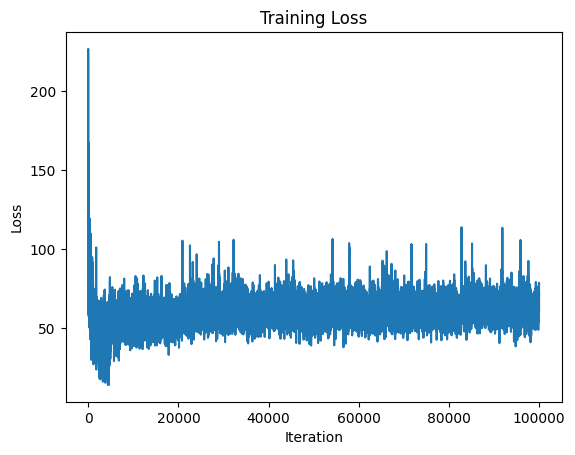

In [62]:
# Initialize the RNN
hidden_size = 100  # You can adjust this
rnn = RNN(vocab_size, hidden_size)

# Train the RNN
train_rnn(rnn, text, char_to_ix, ix_to_char, seq_length=25, num_iterations=100_000, print_every=1_000)

# 2. Study of the IMDB dataset